In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

# Ορίζουμε τη διάσταση του latent space
latent_dim = 2

# Ορίζουμε τον κωδικοποιητή
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_logvar = layers.Dense(latent_dim)

    def call(self, x):
        x = self.dense1(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_logvar(x)
        return z_mean, z_log_var

# Ορίζουμε τον αποκωδικοποιητή
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense_output = layers.Dense(784, activation='sigmoid')

    def call(self, z):
        x = self.dense1(z)
        return self.dense_output(x)

# Ορίζουμε τη συνάρτηση απώλειας (loss function) και τον βελτιστοποιητή (optimizer)
def vae_loss(x, x_recon, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_recon), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Δημιουργούμε το VAE
encoder = Encoder()
decoder = Decoder()

# Συνδέουμε τον κωδικοποιητή με τον αποκωδικοποιητή
inputs = layers.Input(shape=(784,))
z_mean, z_log_var = encoder(inputs)
z = tf.random.normal(tf.shape(z_mean))
z = z_mean + tf.exp(0.5 * z_log_var) * z
outputs = decoder(z)
vae = Model(inputs, outputs)

# Καθορίζουμε τη διαδικασία εκπαίδευσης
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = encoder(x)
        z = tf.random.normal(tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * z
        x_recon = decoder(z)
        loss = vae_loss(x, x_recon, z_mean, z_log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Φορτώνουμε τα δεδομένα MNIST και προετοιμάζουμε το διαχωρισμό τους σε batches
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], -1))
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(250)

# Εκπαιδεύουμε το μοντέλο για 100 εποχές
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, x_batch_train in enumerate(train_dataset):
        loss = train_step(x_batch_train)
        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.numpy()}")

print("Training complete!")


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/100
Step 0: Loss = 173.60952758789062
Step 100: Loss = 71.11190795898438
Step 200: Loss = 64.9925308227539
Epoch 2/100
Step 0: Loss = 64.3818130493164
Step 100: Loss = 64.02096557617188
Step 200: Loss = 61.6795768737793
Epoch 3/100
Step 0: Loss = 61.406429290771484
Step 100: Loss = 60.52452850341797
Step 200: Loss = 59.59682083129883
Epoch 4/100
Step 0: Loss = 59.407745361328125
Step 100: Loss = 57.46467590332031
Step 200: Loss = 57.76044845581055
Epoch 5/100
Step 0: Loss = 58.467750549316406
Step 100: Loss = 56.177730560302734
Step 200: Loss = 57.28327178955078
Epoch 6/100
Step 0: Loss = 56.341373443603516
Step 100: Loss = 55.76067352294922
Step 200: Loss = 57.18167495727539
Epoch 7/100
Step 0: Loss = 58.35011672973633
Step 100: Loss = 55.7718391418457
Step 200: Loss = 56.33539962768555
Epoch 8/100
Step 0: Loss = 57.22426986694336
Step 100: Loss = 56.442955017089844
Step 200: Loss = 57.22035598754883
Epoch 9/100


Visualizing reconstruction for epoch 1
1/1 [==============================] - 0s 86ms/step


Visualizing reconstruction for epoch 50
1/1 [==============================] - 0s 20ms/step


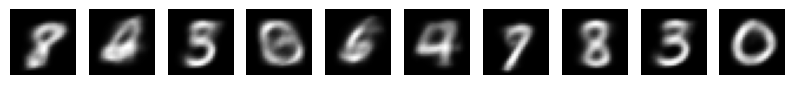

Visualizing reconstruction for epoch 100
1/1 [==============================] - 0s 20ms/step


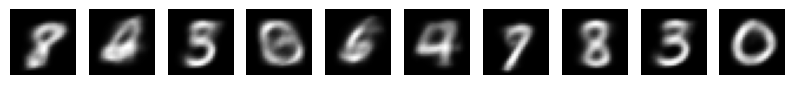

In [4]:
import matplotlib.pyplot as plt

# Δημιουργούμε ένα batch θορύβου από την N(z; 0, I)
num_samples = 10
noise = tf.random.normal(shape=(num_samples, latent_dim))

# Ανακατασκευή για τις εποχές 1, 50 και 100
epochs_to_visualize = [1, 50, 100]
for epoch in epochs_to_visualize:
    print(f"Visualizing reconstruction for epoch {epoch}")
    # Φορτώνουμε τον αποκωδικοποιητή με την τρέχουσα κατάσταση του VAE
    decoder.load_weights(f"decoder_weights_epoch_{epoch}.h5")
    # Ανακατασκευή του batch θορύβου
    reconstructions = decoder.predict(noise)
    # Εμφάνιση των ανακατασκευών
    plt.figure(figsize=(10, 1))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()


In [3]:
# Αποθήκευση των βαρών του αποκωδικοποιητή μετά από κάθε εποχή
for epoch in range(epochs):
    decoder.save_weights(f"decoder_weights_epoch_{epoch+1}.h5")


In [7]:
# Φορτώνουμε τα δεδομένα MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Προεπεξεργασία δεδομένων: κανονικοποίηση των pixel στο διάστημα [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Ανασχηματίζουμε τα δεδομένα σε μια διαστασιότητα (num_samples, 784)
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))




313/313 [==============================] - 1s 3ms/step


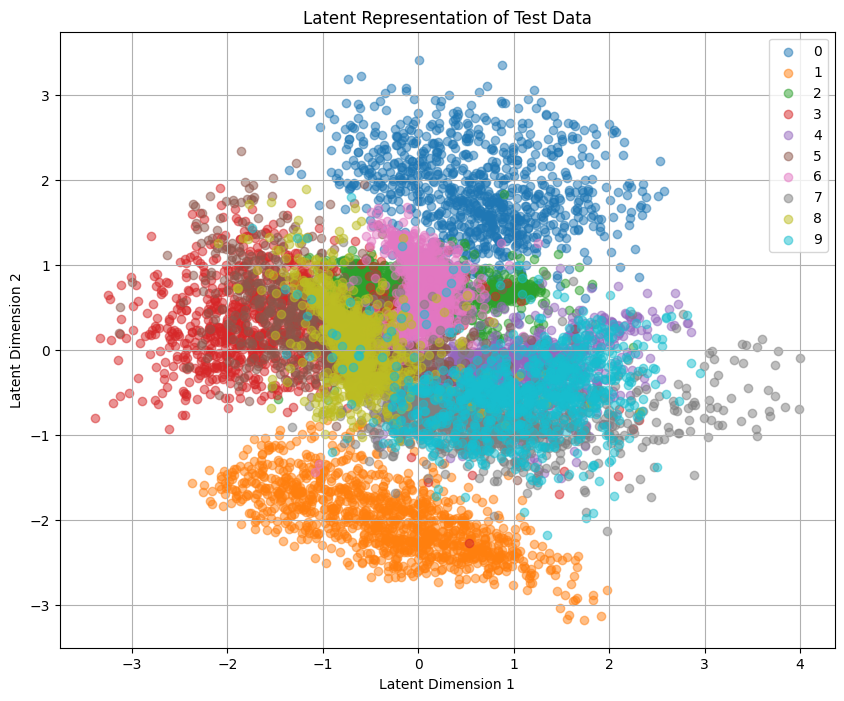

In [8]:
# Δημιουργούμε ένα νέο μοντέλο που παίρνει εισόδους αλλά δίνει εξόδους από τον κωδικοποιητή
encoder_only = Model(inputs, z_mean)

# Περνάμε τα δεδομένα ελέγχου μέσα από τον κωδικοποιητή για να πάρουμε τις αναπαραστάσεις τους στον latent space
encoded_test_data = encoder_only.predict(x_test)

# Δημιουργούμε ένα scatter plot για τις αναπαραστάσεις στον latent space
plt.figure(figsize=(10, 8))
for digit in range(10):
    plt.scatter(encoded_test_data[y_test == digit, 0], encoded_test_data[y_test == digit, 1], label=str(digit), alpha=0.5)
plt.title('Latent Representation of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.show()
